In [1]:

import cv2
import numpy as np
import keras
import os
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Conv2DTranspose, BatchNormalization, Conv2D, Activation, add
from keras.layers import GlobalMaxPooling2D, Flatten, PReLU, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from model import SRCNN, FSRCNN,FSRCNN2, SRCNNex, generator_SR
from keras.optimizers import Nadam, Adam, SGD

Using TensorFlow backend.


In [2]:
def PSNR(y_true, y_pred):
    y_pred = np.round(y_pred)
    MSE = np.mean( np.square( y_true - y_pred ) )
    
    d = 255.0**2
    
    metric = 10.0 * np.log10(d/MSE)
    return metric

def evaluation(model, test_generator, steps):
    preds = []
    batch_x = []
    batch_y = []
    preds_img = []
    for i, (x, y) in enumerate(test_generator.generator()):
        if i == steps:
            break
        y_pred = model.predict(x)
        psnr = PSNR( y, y_pred )
        preds.append(psnr)
        
        batch_x.append(x)
        batch_y.append(y)
        preds_img.append(np.round(y_pred).astype(np.uint8))
    return sum(preds)/len(preds), batch_x, batch_y, preds_img



In [23]:
with open("Set5.txt", "r") as f :
    test = [line.rstrip() for line in f]
    
idx = 2


# SRCNN

In [24]:
K.clear_session()
# load model
scales = 2    
test_gen = generator_SR(test, scales, "SRCNN")
steps_test = test_gen.getSteps()
name_model = "weights/SRCNN.hdf5"
model = SRCNN()
model.summary()

model.load_weights(name_model)
results, LR, HR, preds = evaluation(model, test_gen, steps_test)
print("Evaluation RSCNN : {0}".format(results))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, None, 3)     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 64)    15616     
_________________________________________________________________
mapping (Conv2D)             (None, None, None, 32)    2080      
_________________________________________________________________
output (Conv2D)              (None, None, None, 3)     2403      
_________________________________________________________________
lambda_2 (Lambda)            (None, None, None, 3)     0         
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________
Evalua

In [25]:
srcnn_img = preds[idx][0]
true_img = HR[idx][0]
bicubic = LR[idx][0]

# SRCNNex

In [26]:
K.clear_session()
# load model
scales = 2    
test_gen = generator_SR(test, scales, "SRCNN")
steps_test = test_gen.getSteps()
name_model = "weights/SRCNNex.hdf5"
model = SRCNNex()
model.summary()

model.load_weights(name_model)
results, LR, HR, preds = evaluation(model, test_gen, steps_test)
print("Evaluation RSCNN : {0}".format(results))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, None, 3)     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 64)    15616     
_________________________________________________________________
mapping (Conv2D)             (None, None, None, 32)    51232     
_________________________________________________________________
output (Conv2D)              (None, None, None, 3)     2403      
_________________________________________________________________
lambda_2 (Lambda)            (None, None, None, 3)     0         
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
_________________________________________________________________
Evalua

In [27]:
srcnnex_img = preds[idx][0]

# FSRCNN

In [28]:
K.clear_session()
# load model
scales = 2    

test_gen = generator_SR(test, scales, "FSRCNN")
steps_test = test_gen.getSteps()

name_model = "weights/FSRCNN3.hdf5"
model = FSRCNN(scale=scales)
model.summary()

model.load_weights(name_model)
results, LR, HR, preds = evaluation(model, test_gen, steps_test)
print("Evaluation FRSCNN : {0}".format(results))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, None, 3)     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 56)    4256      
_________________________________________________________________
conv2 (Conv2D)               (None, None, None, 12)    684       
_________________________________________________________________
conv3_0 (Conv2D)             (None, None, None, 12)    1308      
_________________________________________________________________
conv3_1 (Conv2D)             (None, None, None, 12)    1308      
_________________________________________________________________
conv3_2 (Conv2D)             (None, None, None, 12)    1308      
__________

In [29]:

fsrcnn_img = preds[idx][0]

# FSRCNN 2

In [32]:
K.clear_session()
# load model
scales = 2    

test_gen = generator_SR(test, scales, "FSRCNN")
steps_test = test_gen.getSteps()

name_model = "weights/FSRCNN2.hdf5"
model = FSRCNN2(scale=scales)
model.summary()

model.load_weights(name_model)
results, LR, HR, preds = evaluation(model, test_gen, steps_test)
print("Evaluation FRSCNN : {0}".format(results))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, None, 3)     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 56)    4256      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, None, None, 56)    56        
_________________________________________________________________
conv2 (Conv2D)               (None, None, None, 12)    684       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, None, None, 12)    12        
_________________________________________________________________
conv3_0 (Conv2D)             (None, None, None, 12)    1308      
__________

In [33]:
fsrcnn2_img = preds[idx][0]

# Display

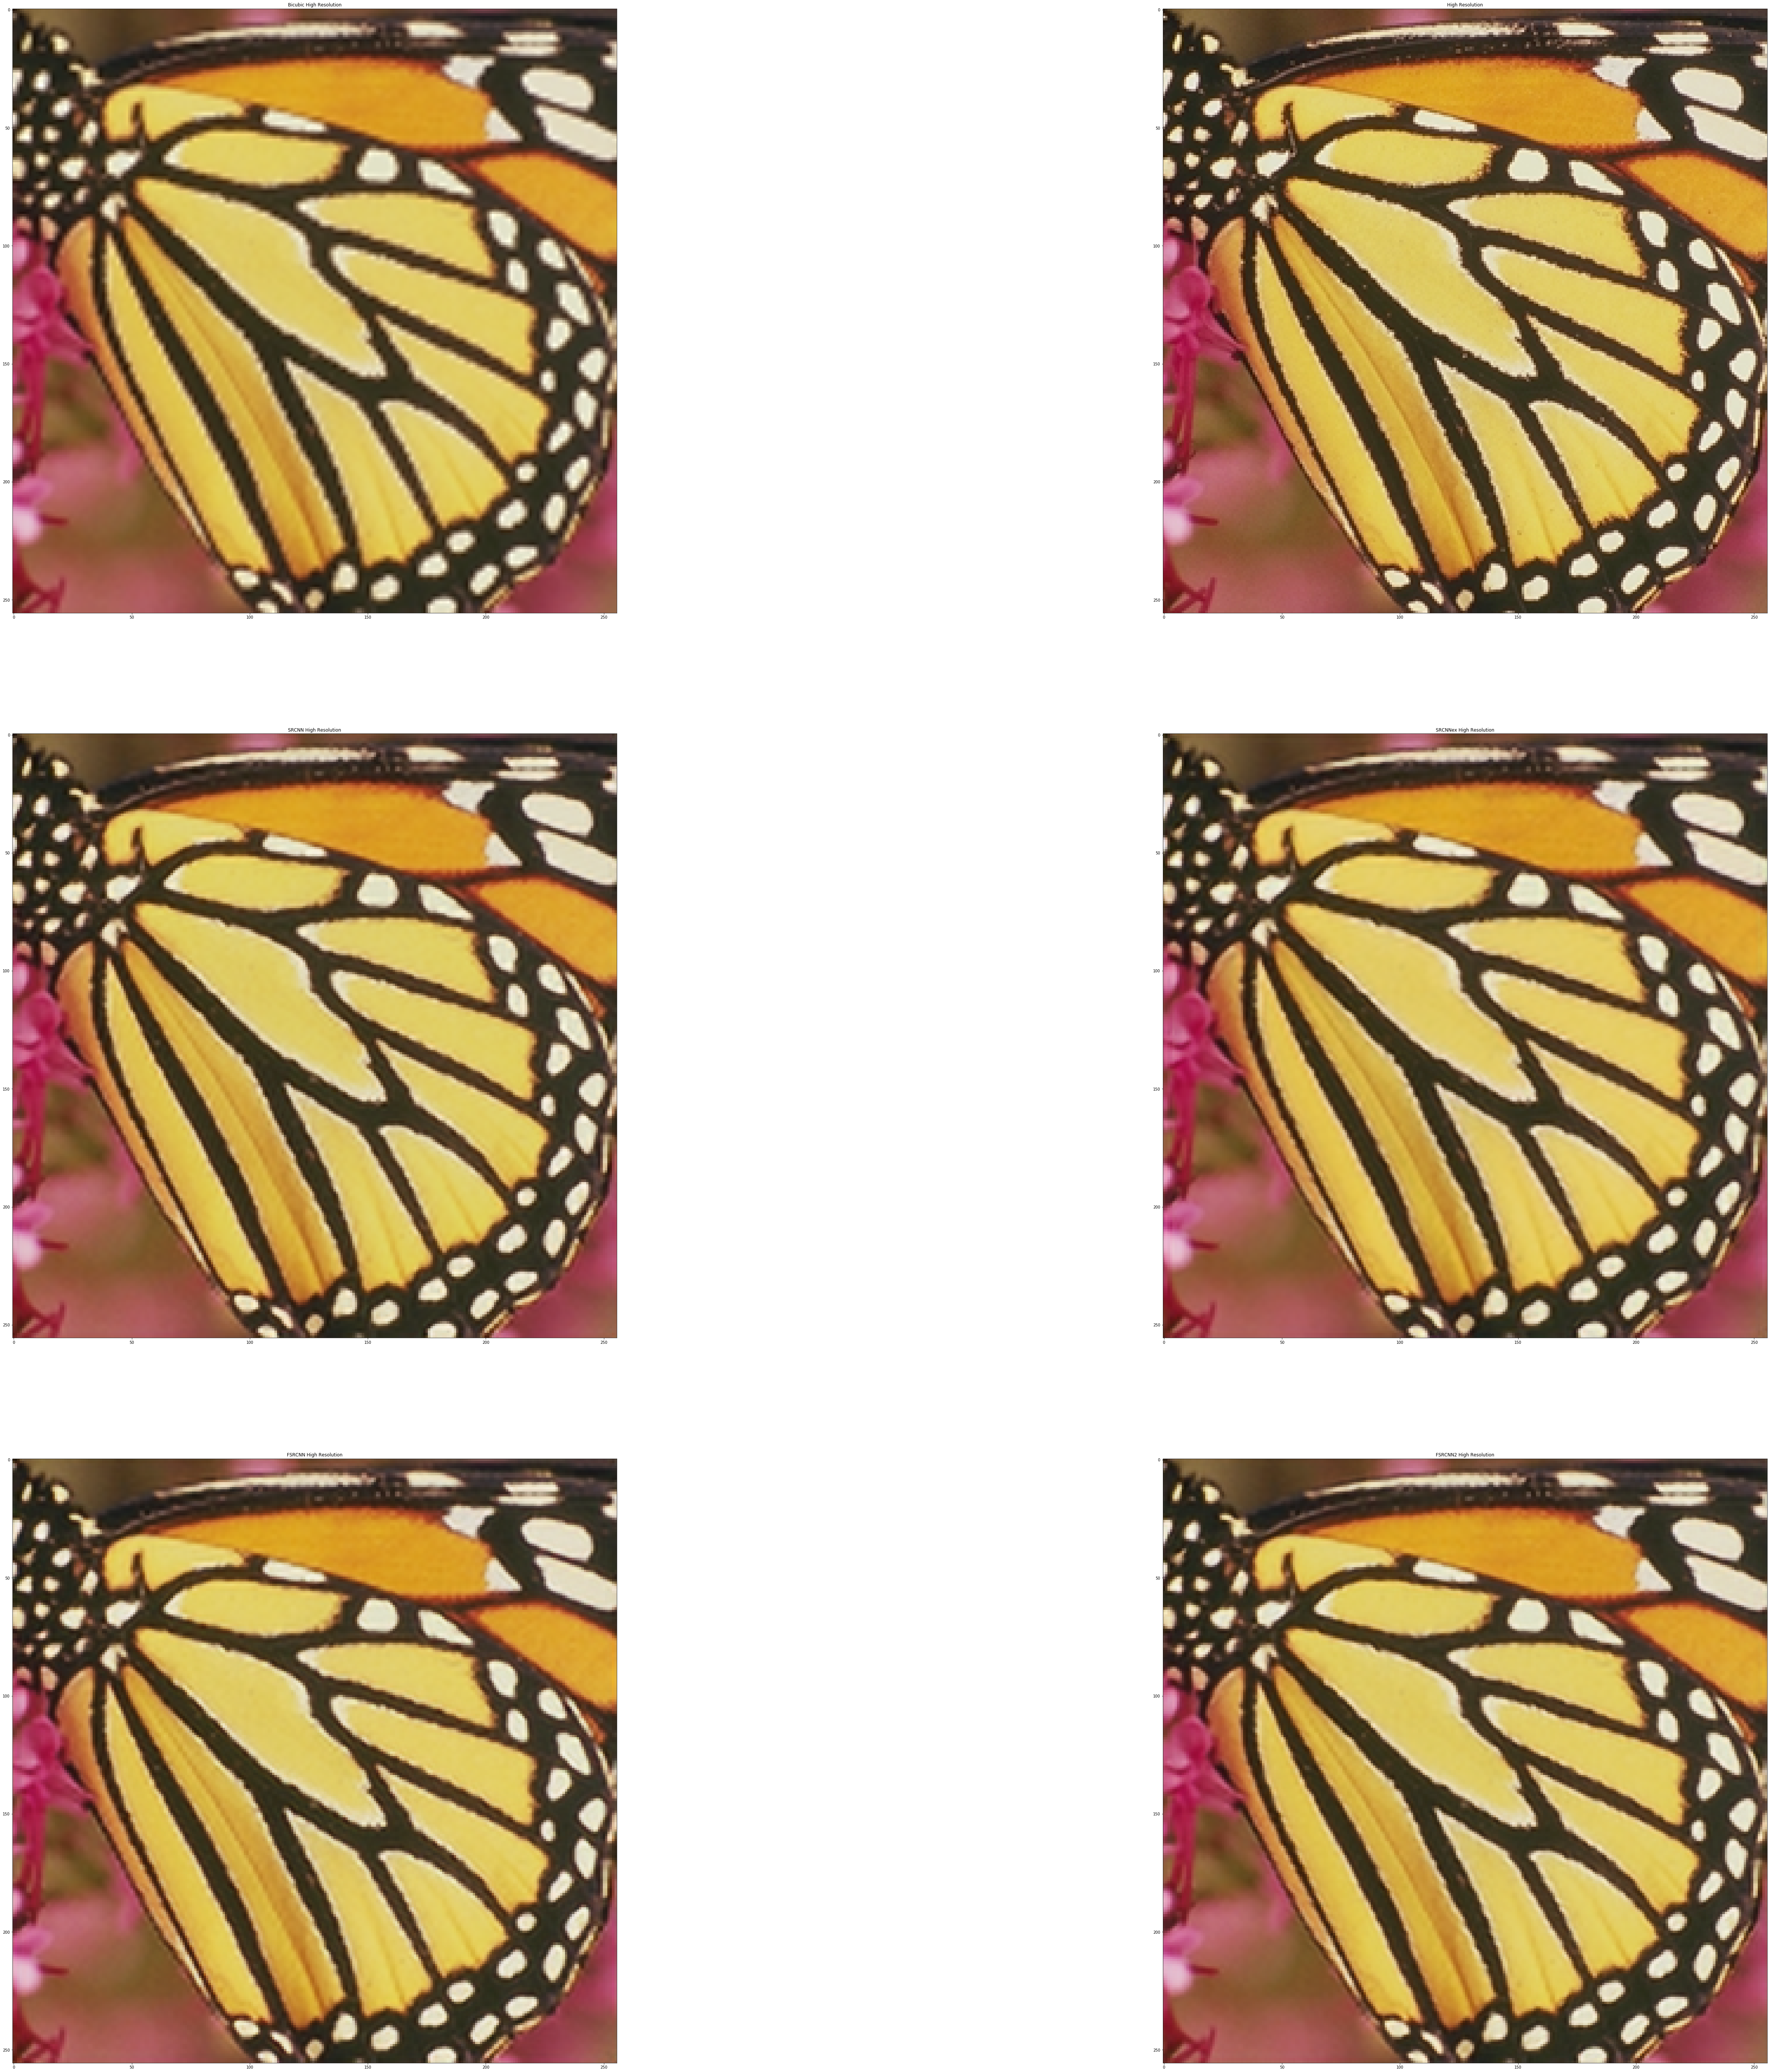

In [34]:
import matplotlib.pyplot as plt
w=100
h=100
fig=plt.figure(figsize=(w,h))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(bicubic[:,:,::-1])
ax1.title.set_text('Bicubic High Resolution')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(true_img[:,:,::-1])
ax2.title.set_text('High Resolution')


ax3 = fig.add_subplot(3,2,3)
ax3.imshow(srcnn_img[:,:,::-1])
ax3.title.set_text('SRCNN High Resolution')

ax4=fig.add_subplot(3,2,4)
ax4.imshow(srcnnex_img[:,:,::-1])
ax4.title.set_text('SRCNNex High Resolution')

ax5=fig.add_subplot(3,2,5)
ax5.imshow(fsrcnn_img[:,:,::-1])
ax5.title.set_text('FSRCNN High Resolution')

ax6=fig.add_subplot(3,2,6)
ax6.imshow(fsrcnn2_img[:,:,::-1])
ax6.title.set_text('FSRCNN2 High Resolution')

In [31]:
print(bicubic.shape)

(256, 256, 3)
